# VK Network Analysis Project


# 1. Network Summary

## Network Source
The source of network is vk and I used vk_api python module `https://pypi.org/project/vk-api/` to load the data from vk. I used vk account of a friend of mine as I created recently my vk account and I have only 24 or 25 friends so It's a few number of nodes. The vk account I used has 550 friends which is 550 number of nodes. This is link to the account used `https://vk.com/artur__avetisyan`

In [311]:
from __future__ import division
import vk_api
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial as spt
import pandas as pd
from collections import Counter
from IPython.display import Image
import seaborn as sns
from typing import List
import scipy
from sklearn.metrics.pairwise import cosine_similarity

In [70]:
username = "username"
password = 'password'
vk_session = vk_api.VkApi(username, password)
vk_session.auth()
vk = vk_session.get_api()
friends_ids = vk.friends.get()["items"]

## Loading & Preprocessing 

In [71]:
graph_realtions = {}
deleted_friends = []

for friend_id in friends_ids:
    try:
        graph_realtions[friend_id] = vk.friends.get(user_id = friend_id)["items"]
    except:
        deleted_friends.append(friend_id)

## setting the nodes and attributes of the graph
In this section, I initialize the graph nodes, pull the rest of the data for each user, setting graph attributes and initializing a dataframe for the user data to do a summary.

In [72]:
G = nx.Graph(directed=False)
for node_i in graph_realtions:
    G.add_node(node_i)
    for node_j in graph_realtions[node_i]:
        if node_i != node_j and node_i in friends_ids and node_j in friends_ids:
            G.add_edge(node_i, node_j)

In [73]:
fields = ['first_name', 'last_name', 'sex', 'relation', 'city', 'education', 'personal']
fields_str = ','.join(fields)

users_data = []
for node in G.nodes:
    users_data.append( vk.users.get(user_ids=str(node), fields=fields_str, lang='en')[0])

In [74]:
graph_data = {
    'id': [user['id'] for user in users_data],
    'name': [user['first_name']+' '+user['last_name'] for user in users_data],
    'sex': [user['sex'] for user in users_data],
    'city': [user['city']['title'] if 'city' in user else 'None' for user in users_data],
    'university': [user['university'] if 'university' in user else 0 for user in users_data],
    'relationship': [user['relation'] if 'relation' in user else 0 for user in users_data],
    'friends': [],
    'smoking': [user['personal']['smoking'] if 'personal' in user and 'smoking' in user['personal'] else 0 for user in users_data],
    'alcohol': [user['personal']['alcohol'] if 'personal' in user and 'alcohol' in user['personal'] else 0 for user in users_data],
    'life_main': [user['personal']['life_main'] if 'personal' in user and 'life_main' in user['personal'] else 0 for user in users_data],
    'people_main': [user['personal']['people_main'] if 'personal' in user and 'people_main' in user['personal'] else 0 for user in users_data]
}

In [78]:
friends_count = []
for i in graph_data['id']:
    try:
        friends_count.append(len(graph_realtions[i]))
    except:
        friends_count.append(0)
graph_data['friends'] = friends_count

In [79]:
G[294517501]

AtlasView({561636: {}, 61790409: {}, 69309044: {}, 99778085: {}, 122527691: {}, 132808235: {}, 145942443: {}})

In [80]:
df = pd.DataFrame(data=graph_data)

In [85]:
df

id                 name  sex    city  university  relationship  \
0       561636     Amalia Avetisyan    1    Perm         730             0   
1     66755554      Elena Avetisyan    1    Perm           0             1   
2    173078569      Diana Avetisyan    1    Perm           0             3   
3    294517501             DELETED     2    None           0             0   
4    332345423  Anzhelika Avetisyan    1    None           0             0   
..         ...                  ...  ...     ...         ...           ...   
536  482272300  Dmitry Morskovatykh    2    Perm           0             1   
537  404905519      Timofey Savinov    2    Perm           0             0   
538  475469183     Sergey Volkonsky    2    None           0             0   
539  500959136          Max Batulin    2    Perm          87             0   
540  581743322         Ehab EL-Kady    2  Moscow         128             0   

     friends  smoking  alcohol  life_main  people_main  
0        527        0        0          0            0  
1        121        0        0          6            0  
2        216        0        0          0            0  
3          0        0        0          0            0  
4        192        0        0          0            0  
..       ...      ...      ...        ...          ...  
536      120        0        0          0            0  
537      188        0        0          0            0  
538        0        0        0          0            0  
539     2112        3        3          4            6  
540       26        0        0          0            0  

[541 rows x 11 columns]

In [82]:
# setting the attributes for the nodes
for key in df:
    if key == 'id':
        continue
    attribute = dict(zip(list(df['id']), list(df[key])))
    nx.set_node_attributes(G, attribute, key)

## Saving the network

I saved the network to be able to retrieve it anytime because I'm not using my profile

In [83]:
nx.write_gml(G, "network_data.gml")

In [86]:
G_test = nx.read_gml('network_data.gml')


## Size and Order

In [87]:
print('Number of Nodes: ', G.number_of_nodes())
print('Number of Edges: ', G.number_of_edges())
print('Number of Connected components: ', nx.number_connected_components(G))

Number of Nodes:  541
Number of Edges:  6745
Number of Connected components:  25


The number of nodes is the the number of friends of the profile used for the analysis and It's less than the total number from the profile because there are some profiles that are blocked or deleted from VK, so they are not included in the analysis. Number of edges is the number of connections formed between nodes.

In [88]:
c_components = list(nx.connected_components(G))
max_len = 0
for i in range(len(c_components)):
    if len(c_components[i]) > max_len:
        max_len = len(c_components[i])
        ind_max = i
    print('component {0} has {1} nodes'.format(i+1, len(c_components[i])))

component 1 has 514 nodes
component 2 has 1 nodes
component 3 has 1 nodes
component 4 has 1 nodes
component 5 has 1 nodes
component 6 has 1 nodes
component 7 has 3 nodes
component 8 has 1 nodes
component 9 has 1 nodes
component 10 has 1 nodes
component 11 has 1 nodes
component 12 has 1 nodes
component 13 has 1 nodes
component 14 has 1 nodes
component 15 has 1 nodes
component 16 has 2 nodes
component 17 has 1 nodes
component 18 has 1 nodes
component 19 has 1 nodes
component 20 has 1 nodes
component 21 has 1 nodes
component 22 has 1 nodes
component 23 has 1 nodes
component 24 has 1 nodes
component 25 has 1 nodes


## Diameter and Radius

For calculating the diameter and radius of the graph it has to be connected. Since the graph is not connected I'll choose the largest connected component of the graph and get it's diameter and radius

In [89]:
sub_G = G.subgraph(c_components[ind_max])

In [116]:
print('Diameter of largest connected component is ', nx.diameter(sub_G))
print('Radius of largest connected component is ', nx.diameter(sub_G)//2)

Diameter of largest connected component is  8
Radius of largest connected component is  4


## Clustering Coefficient

In [135]:
avg_coeff_comp = nx.clustering(G)

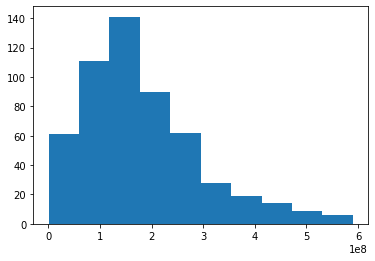

In [136]:
plt.hist(avg_coeff_comp)
plt.show()

In [137]:
print('Average clustering coeeficient for the whole graph is ', nx.algorithms.average_clustering(sub_G))

Average clustering coeeficient for the whole graph is  0.4550181680735725


In [138]:
avg_coeff_comp = nx.clustering(sub_G)

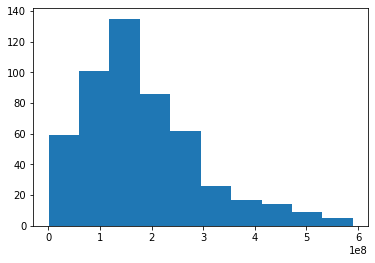

In [139]:
plt.hist(avg_coeff_comp)
plt.show()

## Average path Length 

In [132]:
print('Average shortest path length for the whole graph is ', nx.average_shortest_path_length(sub_G))

Average shortest path length for the whole graph is  2.816263529554539


In [118]:
avg_path_len = {}
nodes = list(sub_G.nodes())
for i in range(len(nodes)):
    path_len = []
    for j in range(len(nodes)):
        shortest_path_len = nx.shortest_path_length(sub_G, nodes[i], nodes[j])
        path_len.append(shortest_path_len)
    avg_path_len[nodes[i]] = np.mean(path_len)

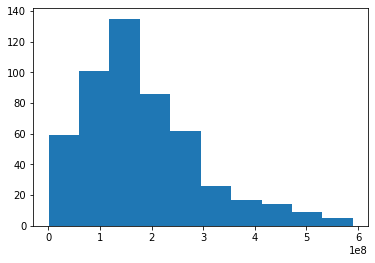

In [119]:
plt.hist(avg_path_len)
plt.show()

## Degree distribution, fitting models and coefficient from regression/MLE/KS-test

In [96]:
degrees = [val for key, val in sub_G.degree()]
n = len(degrees)
deg_dist = pd.value_counts(degrees)
deg_dist.sort_index(inplace=True)
pdf = deg_dist/n
cdf = np.cumsum(pdf)

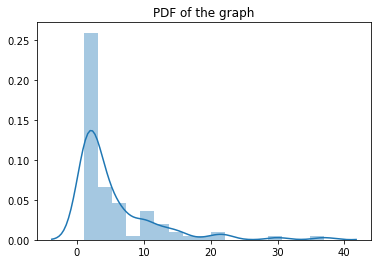

In [129]:
plt.title('PDF of the graph')
sns.distplot(deg_dist)
plt.show()

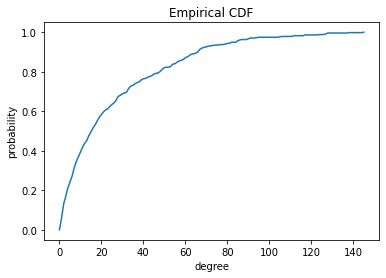

In [299]:
def empirical_cdf(g: nx.Graph) -> List[float]:
    deg = nx.degree_histogram(g)
    deg_cum = np.cumsum(deg)
    return deg_cum/deg_cum[-1]
ecdf = empirical_cdf(sub_G)
plt.plot(ecdf)
plt.xlabel('degree')
plt.ylabel('probability')
plt.title('Empirical CDF')
plt.show()

In [306]:
def power_law_cdf(x, alpha=3.5, x_min=1):
    C = (alpha - 1) / x_min ** (1 - alpha)
    return 1 + C * 1/(-alpha+1) * x ** (-alpha+1)
def power_law_pdf(x, alpha=3.5, x_min=1):
    C = (alpha - 1) / x_min ** (1 - alpha)
    return C * x ** (-alpha)

In [307]:
degree_sequence = [d for n, d in sub_G.degree()]
def mle_power_law_params(degree_sequence):
    deg_seq = np.sort(degree_sequence)
    x_min = range(int(deg_seq[0]), int(deg_seq[-1])+1)
    largest = 0
    for x in x_min:
        deg_seq = deg_seq[deg_seq >= x]
        alpha = 1 + len(deg_seq) * (np.sum(np.log(deg_seq / x)))**-1
        x_space = np.linspace(x, x_min[-1], 100)
        curr = scipy.stats.kstest(deg_seq, cdf=power_law_cdf(x_space, alpha, x))[0]
        if curr > largest:
            largest = curr
            alpha_best = alpha
            x_min_best = x
            
    return alpha_best, x_min_best

/home/ehab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in double_scalars
  
/home/ehab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  
/home/ehab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


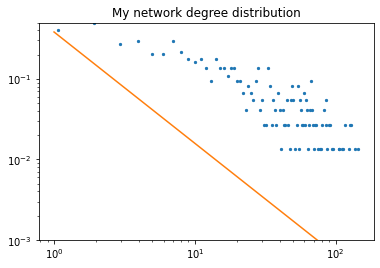

In [308]:
hist, bin_edges = np.histogram(degree_sequence, bins=1000, density=True)
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
plt.scatter(bin_centers[hist > 0], hist[hist > 0], s=5)
plt.title('My network degree distribution')

hat_alpha, hat_x_min = mle_power_law_params(degree_sequence)
x_space = np.linspace(hat_x_min, max(degree_sequence), 100)
plt.plot(x_space, power_law_pdf(x_space, hat_alpha, hat_x_min), 
         label='Estimated PDF', c='tab:orange')
plt.xscale('log')
plt.yscale('log')
plt.ylim(0.001, 0.5);

## Gorgeous network Layout
I used Gephi to produce the layout of my network 

In [99]:
img = 'network_layout.png'
Image(url=img)

This is a graph representation for the sub graph of the biggest connected component

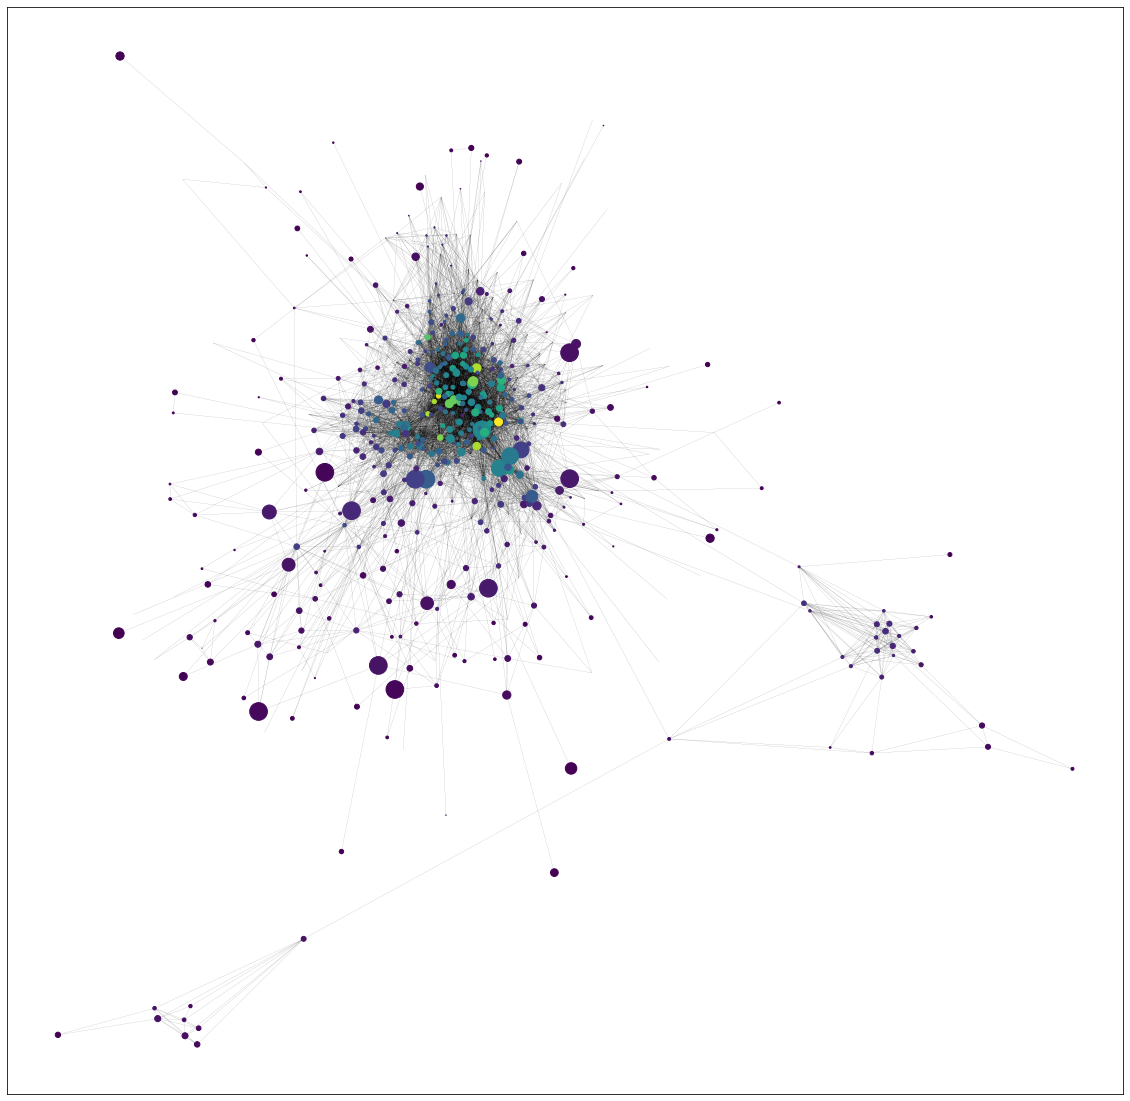

In [270]:
degs = nx.degree(sub_G)
vals = [val for key,val in degs]
plt.figure(figsize=(20,20))
nx.draw_networkx(sub_G, 
                 node_size = [val["friends"]/16 for key, val in sub_G.nodes.items()], 
                 node_color= vals,                 
                 with_labels=False, 
                 width=0.07)

# 2. Structural Analysis

## Close Random Graph

In [228]:
n_nodes = sub_G.number_of_nodes()
n_edges = sub_G.number_of_edges()
avg_degree = np.mean([val for key, val in sub_G.degree()])

In [231]:
erdos_renyi = nx.erdos_renyi_graph(n_nodes, n_edges/(n_nodes*(n_nodes-1)/2))
bar_albert = nx.barabasi_albert_graph(n_nodes, int(n_edges/n_nodes))
watts_strog = nx.watts_strogatz_graph(n_nodes, int(avg_degree), n_edges/(n_nodes*(n_nodes-1)/2))

In [232]:
print('My network data:')
print('number of nodes: ', sub_G.number_of_nodes())
print('number of edges: ', sub_G.number_of_edges())
print('Diameter: ', nx.diameter(sub_G))
print('average clustering coefficient: ', nx.average_clustering(sub_G))
print('average shortest path length: ', nx.average_shortest_path_length(sub_G))
print('-------------------------------------------------------------------------')
print('erdos renyi data:')
print('number of nodes: ', erdos_renyi.number_of_nodes())
print('number of edges: ', erdos_renyi.number_of_edges())
print('Diameter: ', nx.diameter(erdos_renyi))
print('average clustering coefficient: ', nx.average_clustering(erdos_renyi))
print('average shortest path length: ', nx.average_shortest_path_length(erdos_renyi))
print('-------------------------------------------------------------------------')
print('barabasi albert data:')
print('number of nodes: ', bar_albert.number_of_nodes())
print('number of edges: ', bar_albert.number_of_edges())
print('Diameter: ', nx.diameter(bar_albert))
print('average clustering coefficient: ', nx.average_clustering(bar_albert))
print('average shortest path length: ', nx.average_shortest_path_length(bar_albert))
print('-------------------------------------------------------------------------')
print('watts strogatz data:')
print('number of nodes: ', watts_strog.number_of_nodes())
print('number of edges: ', watts_strog.number_of_edges())
print('Diameter: ', nx.diameter(watts_strog))
print('average clustering coefficient: ', nx.average_clustering(watts_strog))
print('average shortest path length: ', nx.average_shortest_path_length(watts_strog))
print('-------------------------------------------------------------------------')

My network data:
number of nodes:  514
number of edges:  6741
Diameter:  8
average clustering coefficient:  0.4550181680735725
average shortest path length:  2.816263529554539
-------------------------------------------------------------------------
erdos renyi data:
number of nodes:  514
number of edges:  6693
Diameter:  3
average clustering coefficient:  0.04782936727604088
average shortest path length:  2.2013865186095374
-------------------------------------------------------------------------
barabasi albert data:
number of nodes:  514
number of edges:  6513
Diameter:  3
average clustering coefficient:  0.10813804165342536
average shortest path length:  2.215646119189023
-------------------------------------------------------------------------
watts strogatz data:
number of nodes:  514
number of edges:  6682
Diameter:  4
average clustering coefficient:  0.615797475324073
average shortest path length:  2.810681047625549
--------------------------------------------------------------

After generating the three different graphs using the 3 different models we can say the closest to my network is watts strogatz as it has diameter closer to my network also the clustering coeff and average shortest path length is closer to my network

## Centralities calculations

In [146]:
centralities = {
    'degree_centrality' : nx.degree_centrality(sub_G),
    'betweenness_centrality' : nx.betweenness_centrality(sub_G),
    'closeness_centrality' : nx.closeness_centrality(sub_G),
    'page_rank' : nx.pagerank(sub_G)
}

In [197]:
for key_1, centrality in centralities.items():
    rank_dict = {}
    for rank, key in enumerate(sorted(centrality, key = centrality.get, reverse=True), 1):
        rank_dict[key] = rank
    nx.set_node_attributes(sub_G, centrality, key_1)
    nx.set_node_attributes(sub_G, rank_dict, key_1+'_rank')
    print(key_1+'_rank')

degree_centrality_rank
betweenness_centrality_rank
closeness_centrality_rank
page_rank_rank


In [170]:
data_items = {}
for node, data in sub_G.nodes.data():
    data_items['id']=node
    for item in data:
        if item in data_items:
            data_items[item].append(data[item])
        else:
            data_items[item] = [data[item]]
cents_df = pd.DataFrame(data = data_items)

In [171]:
cents_df.head()

id                 name  sex  city  university  relationship  \
0  500959136     Amalia Avetisyan    1  Perm         730             0   
1  500959136      Elena Avetisyan    1  Perm           0             1   
2  500959136      Diana Avetisyan    1  Perm           0             3   
3  500959136             DELETED     2  None           0             0   
4  500959136  Anzhelika Avetisyan    1  None           0             0   

   friends  smoking  alcohol  life_main  people_main  500959136  \
0      527        0        0          0            0   0.007797   
1      121        0        0          6            0   0.003899   
2      216        0        0          0            0   0.038986   
3        0        0        0          0            0   0.013645   
4      192        0        0          0            0   0.064327   

   degree_centrality  degree_centrality_rank  betweenness_centrality  \
0           0.007797                     406                0.000384   
1           0.003899                     448                0.000000   
2           0.038986                     215                0.013829   
3           0.013645                     354                0.000655   
4           0.064327                     147                0.038369   

   betweenness_centrality_rank  closeness_centrality  \
0                          293              0.314724   
1                          453              0.291477   
2                           35              0.410400   
3                          250              0.335294   
4                            7              0.416396   

   closeness_centrality_rank  page_rank  page_rank_rank  
0                        410   0.000867             382  
1                        448   0.000579             446  
2                        149   0.002417             142  
3                        368   0.000877             379  
4                        133   0.004636              37

## Plotting and drawing the network for each centrality 

### - Degree centrality

In [201]:
deg_df = cents_df[['id', 'name', 'degree_centrality', 'degree_centrality_rank']]
deg_df = deg_df.sort_values('degree_centrality_rank', ascending=True)
deg_df.head()

id                 name  degree_centrality  degree_centrality_rank
159  500959136         Grisha Gorev           0.282651                       1
118  500959136  Mikhail Mekhonoshin           0.269006                       2
86   500959136       Sergey Mogilev           0.249513                       3
122  500959136      Irina Baskevich           0.249513                       4
181  500959136     Mikhail Ogibalov           0.247563                       5

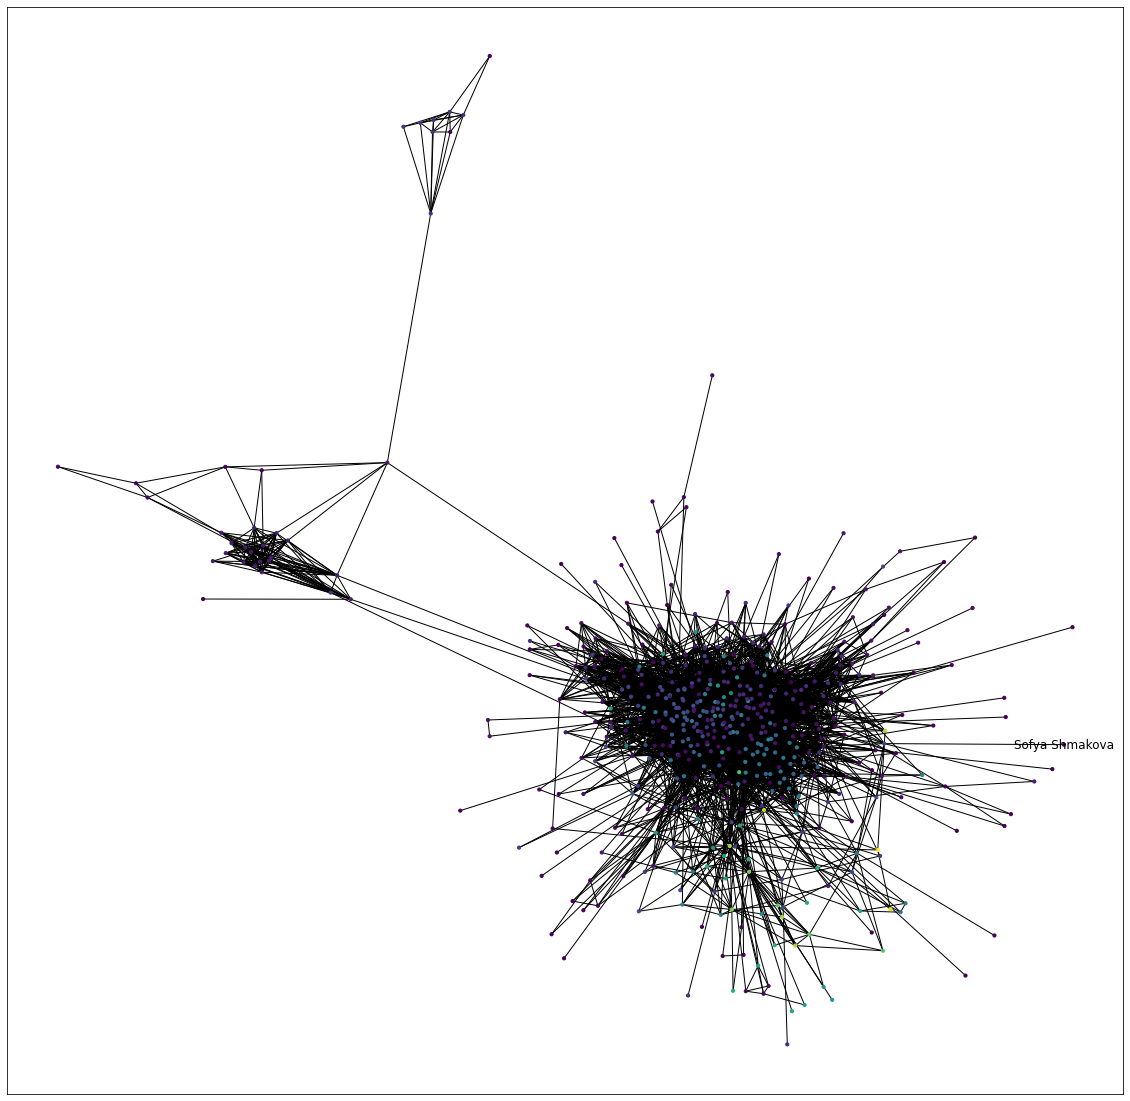

In [202]:
labels_dict = {list(deg_df['id'].values)[i]:list(deg_df['name'].values)[i] for i in range(len(list(deg_df['name'].values)[i]))}
plt.figure(figsize=(20,20))
nx.draw_networkx(sub_G,
                node_size=10,
                node_color= deg_df['degree_centrality'].values,
                labels=labels_dict)

### - Betweeness centrality

In [203]:
bet_df = cents_df[['id', 'name', 'betweenness_centrality', 'betweenness_centrality_rank']]
bet_df = bet_df.sort_values('betweenness_centrality_rank')
bet_df.head()

id                name  betweenness_centrality  \
109  500959136       Makar Bobylev                0.115111   
159  500959136        Grisha Gorev                0.058767   
164  500959136       Darya Naumova                0.057087   
193  500959136  Alexander Golyshev                0.056202   
297  500959136      Kamil Sayakhov                0.052855   

     betweenness_centrality_rank  
109                            1  
159                            2  
164                            3  
193                            4  
297                            5

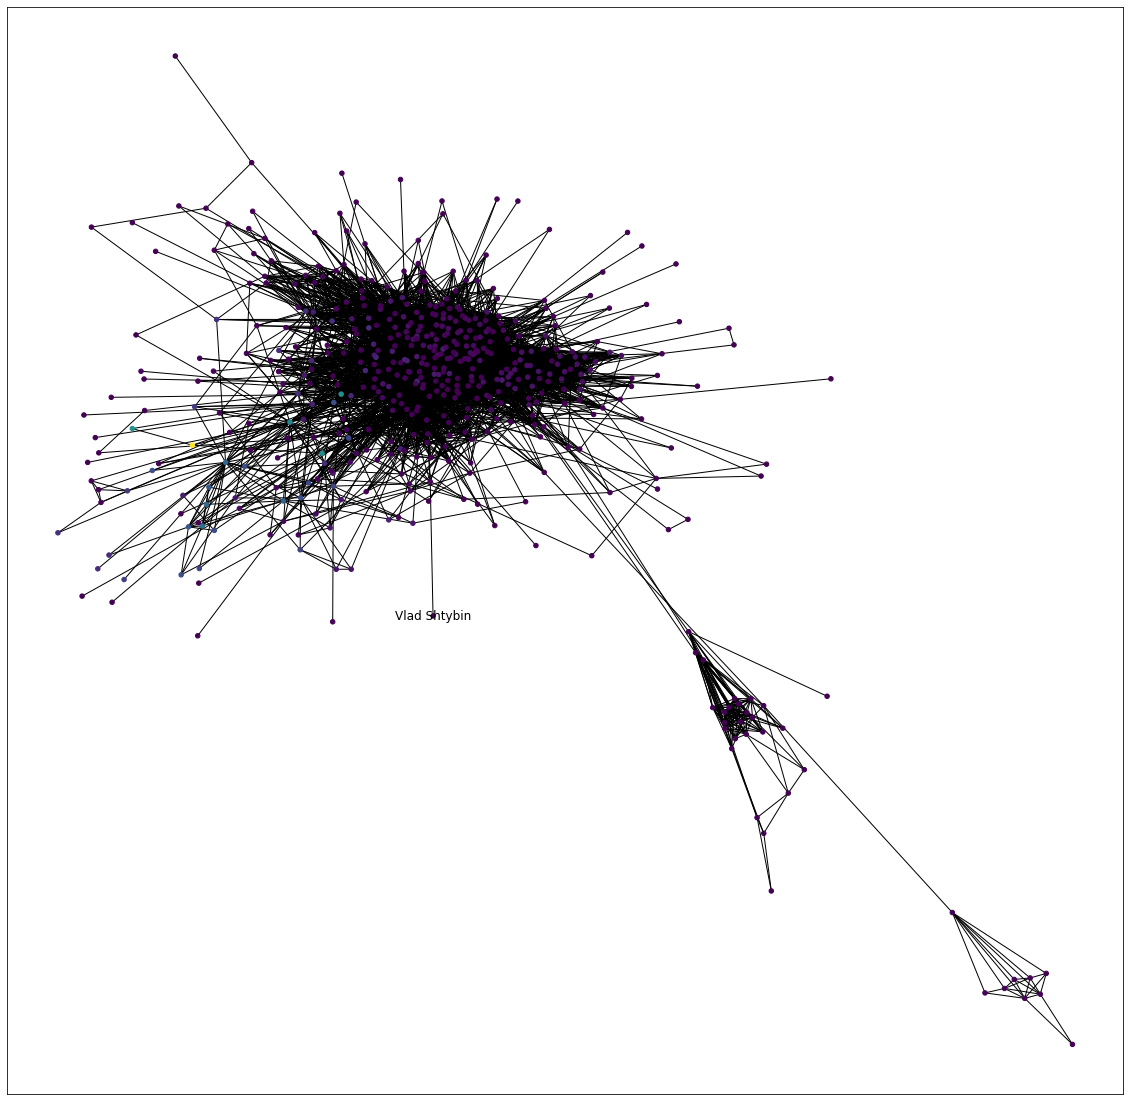

In [210]:
labels_dict = {list(bet_df['id'].values)[i]:list(bet_df['name'].values)[i] for i in range(len(list(bet_df['name'].values)[i]))}
plt.figure(figsize=(20,20))
nx.draw_networkx(sub_G,
                node_size=20,
                node_color= bet_df['betweenness_centrality'].values,
                labels=labels_dict)

### - Closeness centrality

In [205]:
close_df = cents_df[['id', 'name', 'closeness_centrality', 'closeness_centrality_rank']]
close_df = close_df.sort_values('closeness_centrality_rank')
close_df.head()

id                 name  closeness_centrality  \
193  500959136   Alexander Golyshev              0.517137   
118  500959136  Mikhail Mekhonoshin              0.513000   
159  500959136         Grisha Gorev              0.510956   
109  500959136        Makar Bobylev              0.501466   
86   500959136       Sergey Mogilev              0.497093   

     closeness_centrality_rank  
193                          1  
118                          2  
159                          3  
109                          4  
86                           5

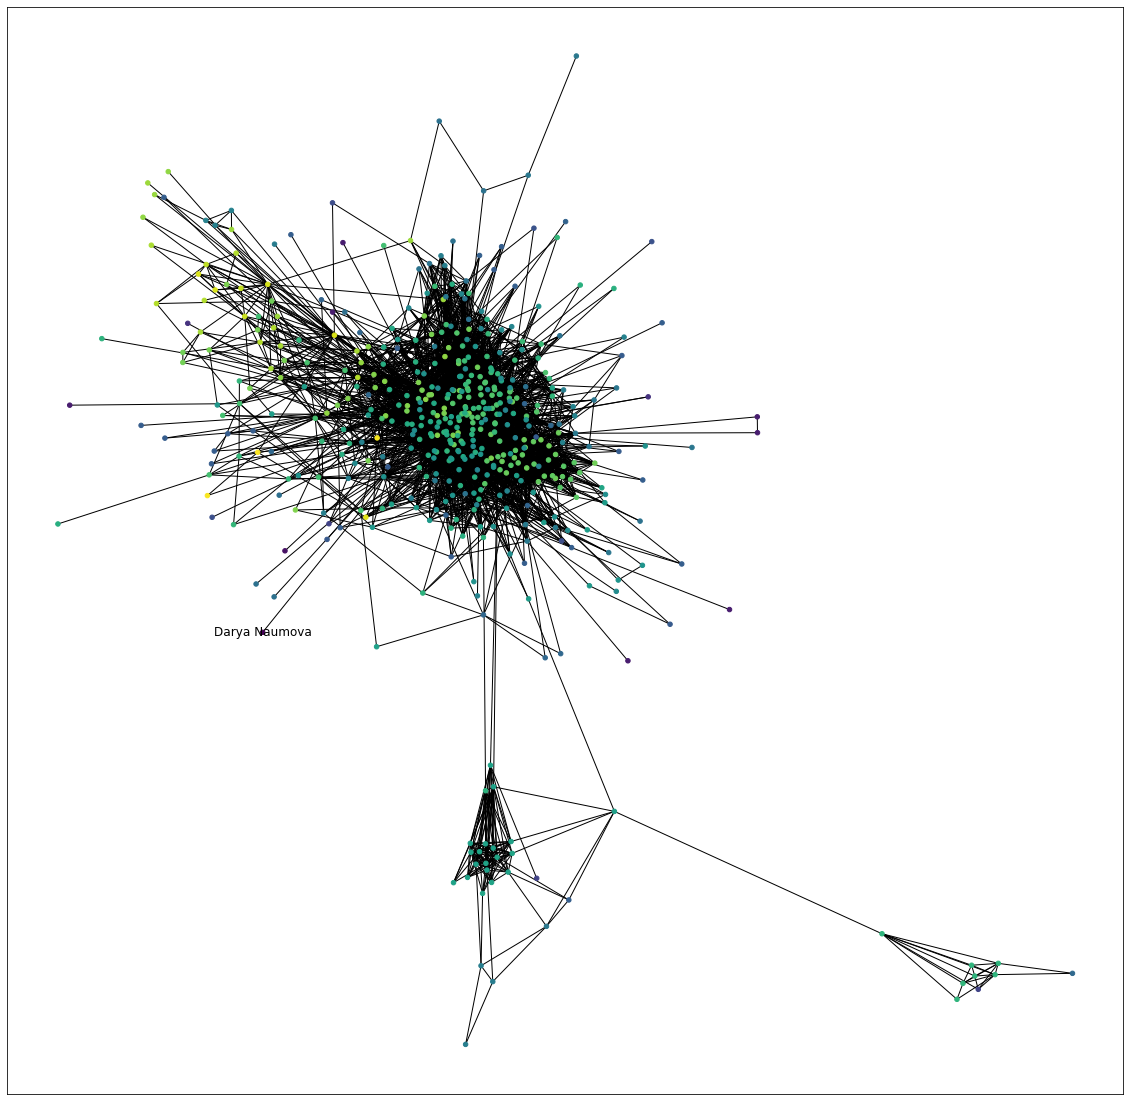

In [206]:
labels_dict = {list(close_df['id'].values)[i]:list(close_df['name'].values)[i] for i in range(len(list(close_df['name'].values)[i]))}
plt.figure(figsize=(20,20))
nx.draw_networkx(sub_G,
                node_size=20,
                node_color= close_df['closeness_centrality'].values,
                labels=labels_dict)

### - Page Rank

In [207]:
p_df = cents_df[['id', 'name', 'page_rank', 'page_rank_rank']]
p_df = p_df.sort_values('page_rank_rank')
p_df.head()

id                 name  page_rank  page_rank_rank
159  500959136         Grisha Gorev   0.008971               1
118  500959136  Mikhail Mekhonoshin   0.008054               2
193  500959136   Alexander Golyshev   0.007934               3
109  500959136        Makar Bobylev   0.007688               4
164  500959136        Darya Naumova   0.007656               5

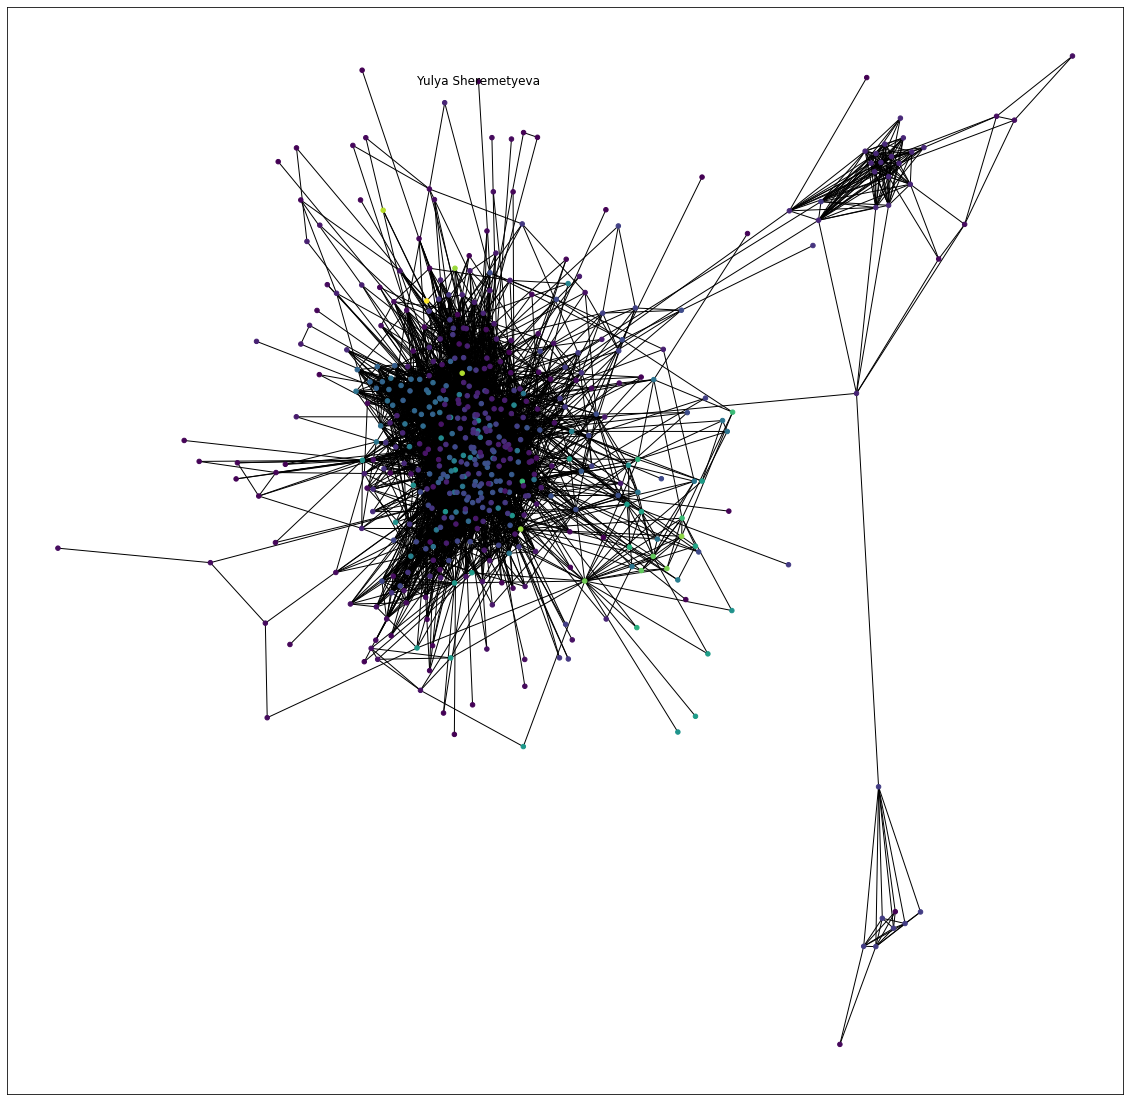

In [208]:
labels_dict = {list(p_df['id'].values)[i]:list(p_df['name'].values)[i] for i in range(len(list(p_df['name'].values)[i]))}
plt.figure(figsize=(20,20))
nx.draw_networkx(sub_G,
                node_size=20,
                node_color= p_df['page_rank'].values,
                labels=labels_dict)

### comparing pagerank with the three centralities 

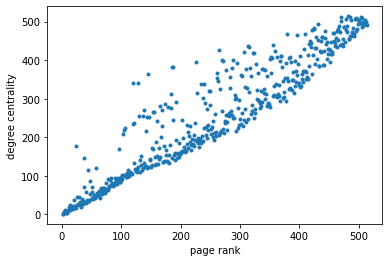

In [219]:
plt.plot(list(nx.get_node_attributes(sub_G, 'page_rank_rank').values()), list(nx.get_node_attributes(sub_G, 'degree_centrality_rank').values()), '.')
plt.xlabel('page rank')
plt.ylabel('degree centrality')
plt.show()

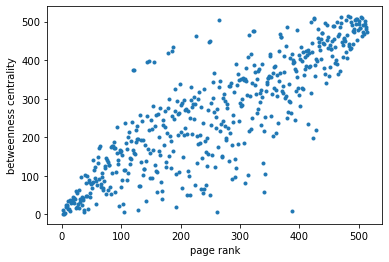

In [220]:
plt.plot(list(nx.get_node_attributes(sub_G, 'page_rank_rank').values()), list(nx.get_node_attributes(sub_G, 'betweenness_centrality_rank').values()), '.')
plt.xlabel('page rank')
plt.ylabel('betweenness centrality')
plt.show()

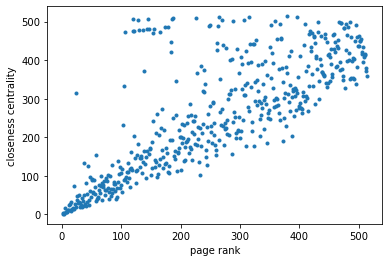

In [224]:
plt.plot(list(nx.get_node_attributes(sub_G, 'page_rank_rank').values()), list(nx.get_node_attributes(sub_G, 'closeness_centrality_rank').values()), '.')
plt.xlabel('page rank')
plt.ylabel('closeness centrality')
plt.show()

## Assortitive mixing for sex, education, city and realtionship

In [225]:
attributes = ['sex', 'city', 'university', 'relationship']
for attribute in attributes:
    assort_mix = nx.attribute_assortativity_coefficient(sub_G, attribute)
    print('assortitive mixing coefficient for {0} is {1}'.format(attribute, assort_mix))

assortitive mixing coefficient for sex is 0.19115912939512733
assortitive mixing coefficient for city is 0.011035007111909911
assortitive mixing coefficient for university is 0.07173541967629717
assortitive mixing coefficient for relationship is 0.0016533432018281957


## Node structural equivalence/similarity

Using the similarity method in link structure homework, I computed the similarity matrices of the network and used heatmaps to plot them using correlation coefficient, jacard coefficient and cosine similarity.

In [309]:
def sim_matrices(G):
    A = nx.to_numpy_array(G)
    p = np.corrcoef(A)
    J = np.zeros(A.shape)
    for i, j, c in nx.jaccard_coefficient(nx.from_numpy_array(A)):
        J[i,j] = c
        J[j,i] = c
    c = cosine_similarity(A)
    return A, p, J, c

In [312]:
A, corr, J, cos = sim_matrices(sub_G)

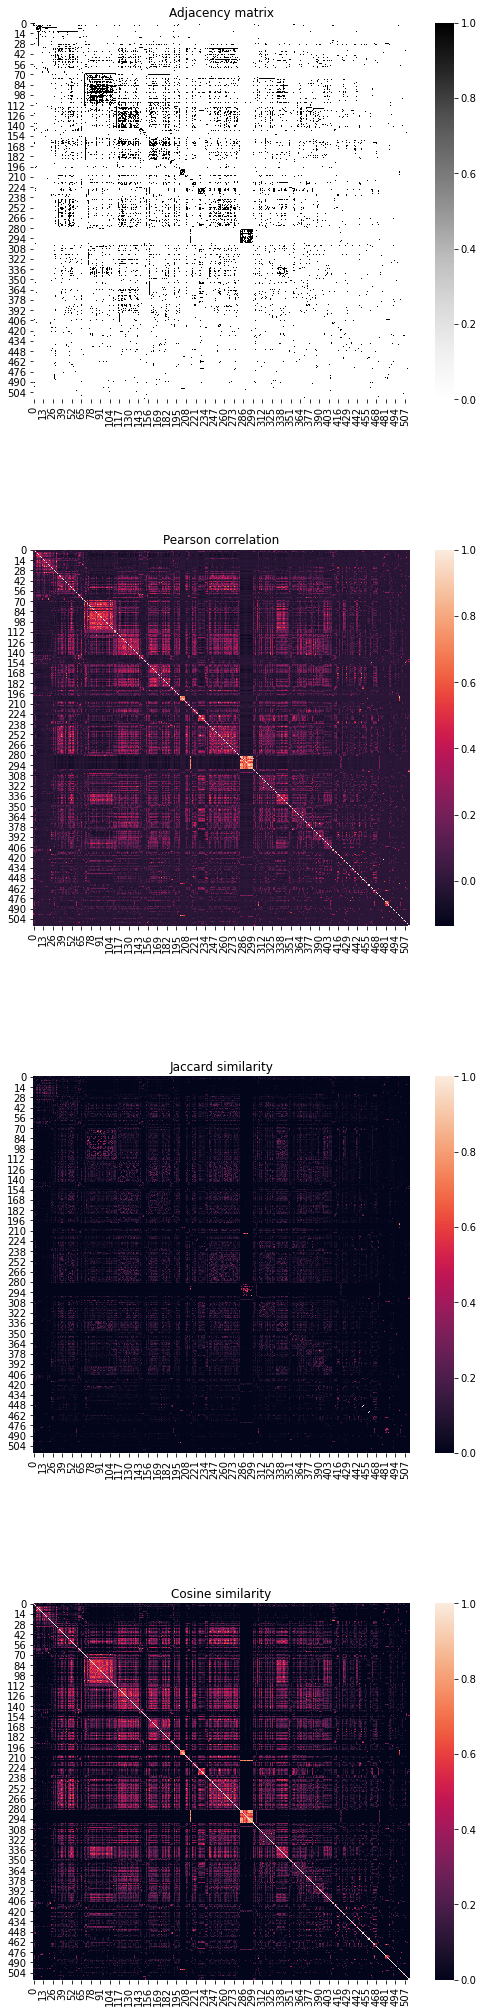

In [316]:
labs = nx.get_node_attributes(sub_G, "name")
fig = plt.figure(figsize=(9, 9*4))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
cases = [[1, A, plt.cm.Greys, 'Adjacency matrix'], 
         [2, corr, None, 'Pearson correlation'], 
         [3, J, None, 'Jaccard similarity'], 
         [4, cos, None, 'Cosine similarity'], ]
for i, matrix, cmap, t in cases:
    plt.subplot(4, 1, i)
    hmap = sns.heatmap(
        matrix,
        cmap=cmap,
        square=True)
    plt.title(t)

We can see from the matrices there is no similarity between nodes and equivilance is really small between nodes that means that profiles are different from each other

# 3. Community Detection

## Clique search, k-cores visualization and interpretation

In [242]:
print('number of cliques in the graph: ', nx.graph_number_of_cliques(sub_G))
cliques = nx.find_cliques(sub_G)
max_clique = {}
for clique in cliques:
    if len(clique) > len(max_clique):
        max_clique = clique

number of cliques in the graph:  13595


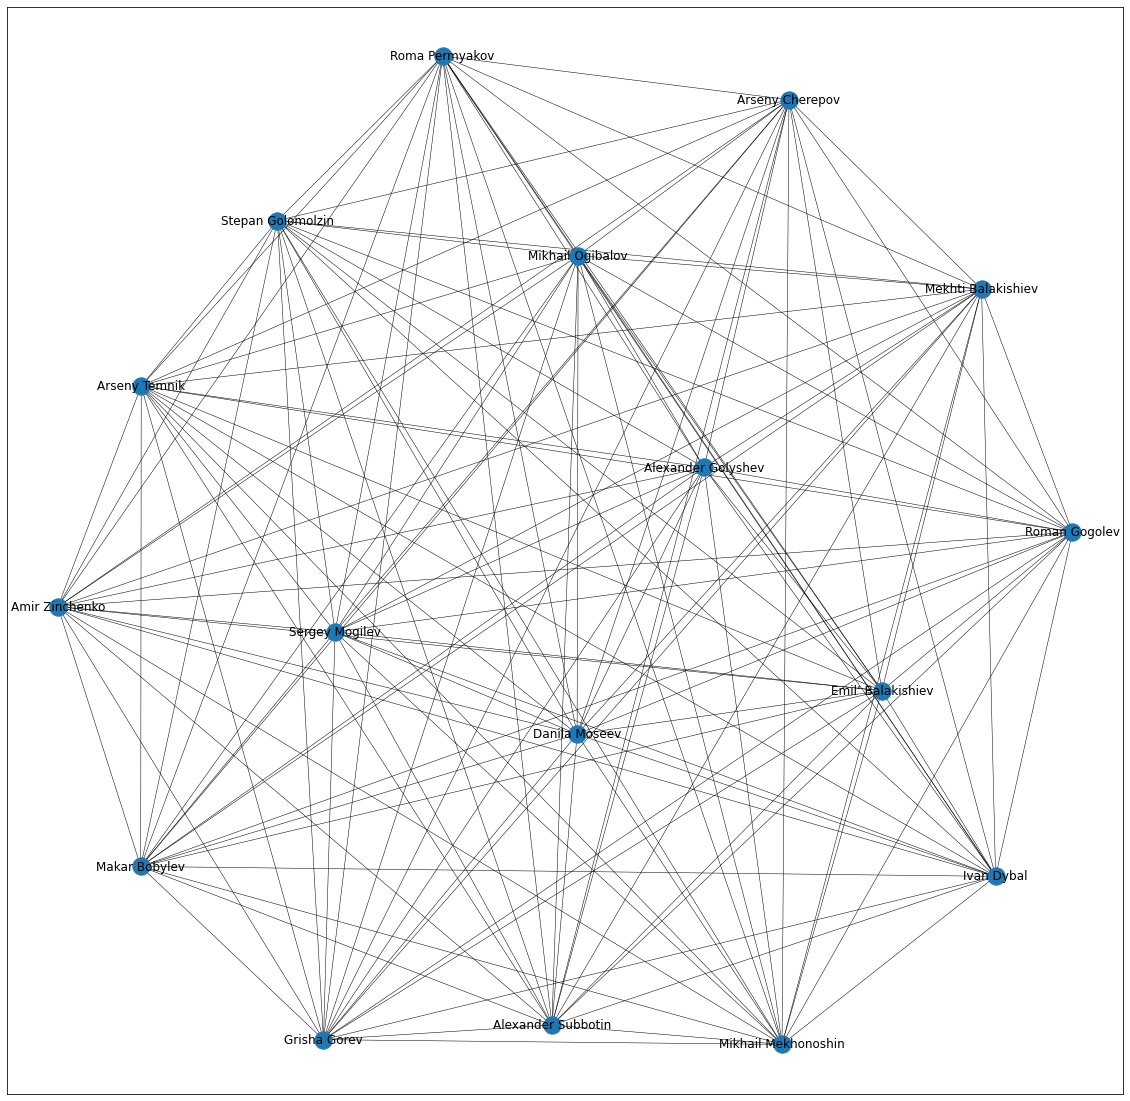

In [252]:
# plotting the max clique
max_clique_graph = sub_G.subgraph(max_clique)
graph_labels = {key:val['name'] for key, val in max_clique_graph.nodes(data=True)}
plt.figure(figsize=(20,20))
nx.draw_networkx(max_clique_graph,
                labels=graph_labels,
                width=0.5)

this is the graph of the maximal clique that has 17 friends of the network used

<Figure size 1152x2304 with 0 Axes>

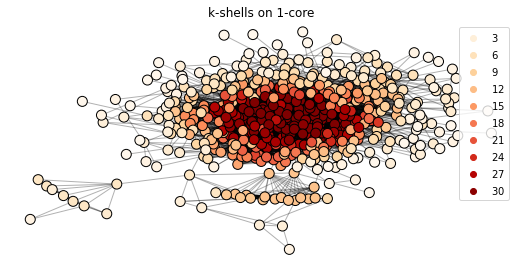

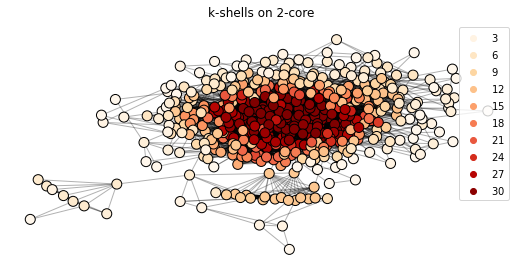

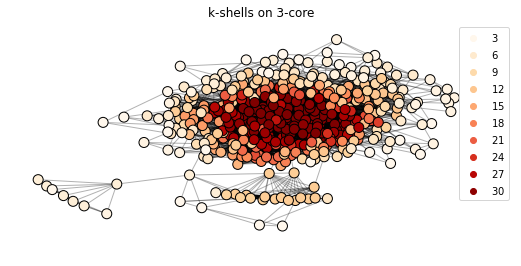

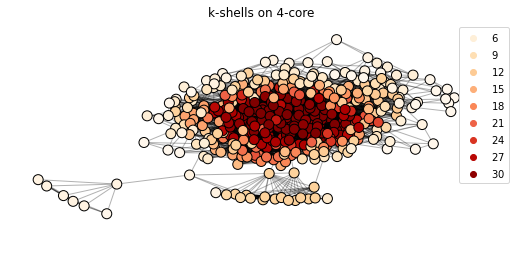

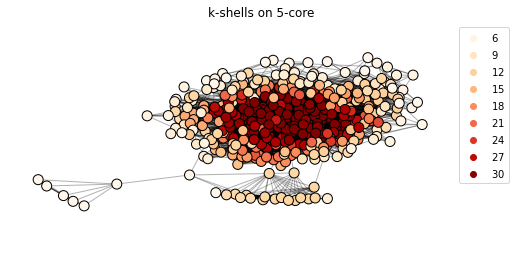

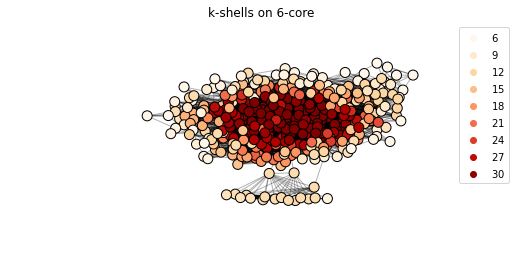

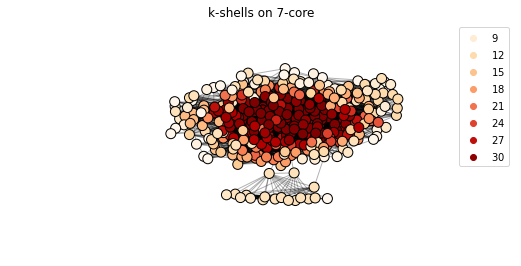

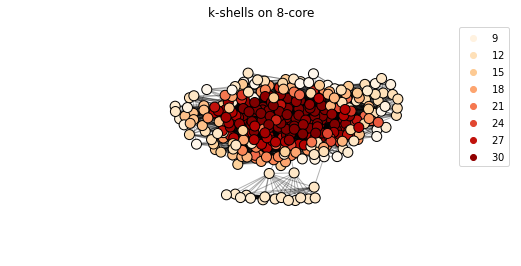

In [286]:
pos = nx.kamada_kawai_layout(sub_G)
def k_core_decompose(G):
    nodes_core = nx.core_number(G)
    k_list = [nodes_core[key] for key in nodes_core]
    return np.array(k_list)
plt.figure(figsize=(8*2, 8*4))
x_max, y_max = np.array(list(pos.values())).max(axis=0)
x_min, y_min = np.array(list(pos.values())).min(axis=0)
for i in range(8):
    plt.figure(figsize=(20,20))
    plt.subplot(4, 2, i+1)
    subG = nx.k_core(sub_G, i+1)
    nodes = nx.draw_networkx_nodes(
        subG, 
        pos,
        cmap=plt.cm.OrRd,
        node_color=k_core_decompose(subG), 
        node_size=100, 
        edgecolors='black'
    )
    nx.draw_networkx_edges(
        subG, 
        pos,
        alpha=0.3,
        width=1, 
        edge_color='black'
    )
    eps = (x_max - x_min) * 0.05
    plt.xlim(x_min-eps, x_max+eps)
    plt.ylim(y_min-eps, y_max+eps)
    plt.legend(*nodes.legend_elements())
    plt.axis('off')
    plt.title('k-shells on {}-core'.format(i+1))

as we can see from the graph the nodes that appear clearly have high k cores which means they have the largest value of k the node can reach for k-core. I used the method I implemented in the homework to get the k-core shells and plot them to define different cores among nodes

## Community Detection
In this section I used the communites homework methods that used greedy algorithm of modularity and then had a color for each community to draw it with

In [329]:
communities = list(nx.algorithms.community.greedy_modularity_communities(sub_G))
colors = {}
for i in range(len(communities)):
    for node in communities[i]:
        colors[node] = i
colors_list = [colors[n] for n in sub_G.nodes()]

Text(0.5, 1.0, '514 nodes, 8 communities Modularity 0.33')

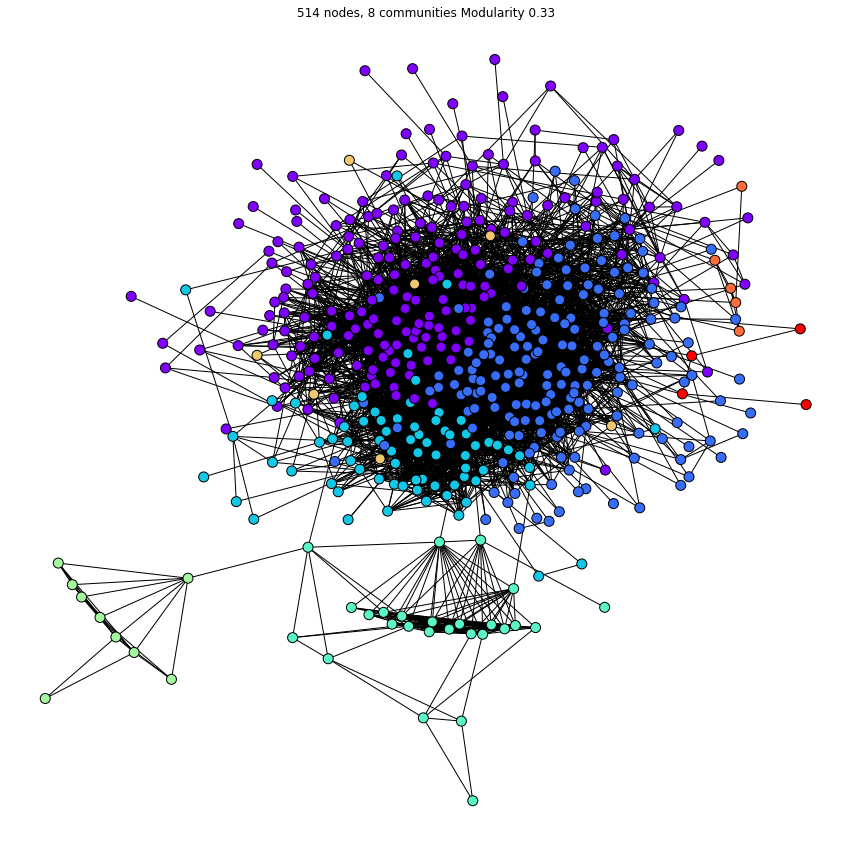

In [335]:
plt.figure(figsize=(15, 15))
nodes = nx.draw_networkx_nodes(
        sub_G,
        pos,
        cmap=plt.cm.rainbow,
        node_color=colors_list,
        edgecolors='black',
        node_size=100)
nx.draw_networkx_edges(
        sub_G,
        pos,
        node_size=100)
plt.axis('off')
plt.title(
        '{} nodes, {} communities Modularity {:.2f}'.format(
            len(sub_G), len(communities), nx.community.modularity(sub_G, communities)))

Here we have 8 different communities among nodes. The profile is not mine to categorize them or make sure are the communities correct or not but from the analysis and connections between profiles, these are the available communities.